# Lab 4

## Kovaleva Maria

## Task:
Demonstrate the lottery ticket hypothesis. Train a 3-layer network on a CIFAR-10. For p=[10, 20, ... 90] select multiple subnetworks with p% of parameters. And retrain them. For each percentage select the network with best performance. Visualize performance depndency on p.


##Theory:

The Lottery Ticket Hypothesis. A randomly-initialized, dense neural network contains a subnetwork that is initialized such that—when trained in isolation—it can match the test accuracy of the
original network after training for at most the same number of iterations.


In [1]:
import jax
from sklearn import datasets
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np
from jax import grad, value_and_grad

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt


In [2]:
def one_hot_encoding(a):
  b = np.zeros((a.size, a.max() + 1))
  b[np.arange(a.size), a] = 1
  return b

170498071/170498071 [==============================] - 4s 0us/step


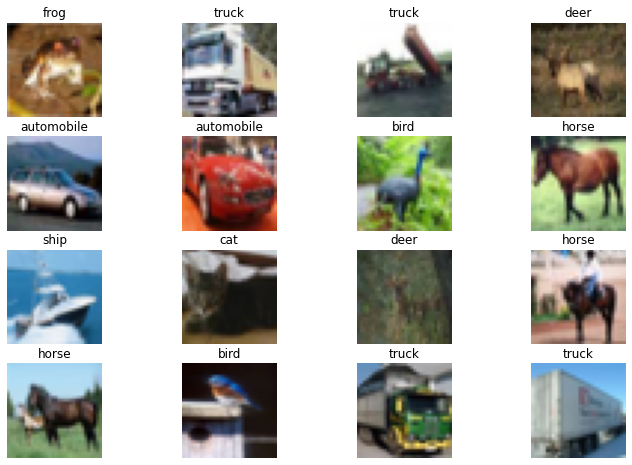

(50000, 3072) (50000, 10) (10000, 3072) (10000, 10)


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
labels_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def plot_samples(x, y, figsize=(12, 8), num_rows=4, num_columns=4, title=None):
    
    if len(x) != len(y):
        raise ValueError("Number of images and number of labels don't match!")
    
    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for i in range(num_rows * num_columns):
        try:
            img = x[i]
            label = str(y[i])
            ax[i // num_columns, i % num_columns].imshow(img)
            ax[i // num_columns, i % num_columns].set_title(label)
            ax[i // num_columns, i % num_columns].axis("off")
        except:
            pass
    
    if title:
        plt.suptitle(str(title))
    plt.show()

plot_samples(x_train[:16], [labels_dict[y[0]] for y in y_train[:16]])

x_train = jnp.array(x_train / 255.)
x_test = jnp.array(x_test / 255.)

x_train, x_test = x_train.reshape(len(x_train),-1), x_test.reshape(len(x_test),-1)
y_train = one_hot_encoding(y_train.reshape(-1))#.astype("int")
y_test = one_hot_encoding(y_test.reshape(-1))#.astype("int")

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [4]:
samples, features = x_train.shape
classes = np.unique(y_train, axis = 0)
samples, features, classes

(50000, 3072, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [5]:
def InitializeWeights(layer_sizes, seed):
    weights = []
    for i, units in enumerate(layer_sizes):
        if i == 0:
            w = jax.random.uniform(key=seed, shape=(units, features), minval=-1.0, maxval=1.0, dtype=jnp.float32)
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        weights.append([w,b])

    return weights

In [6]:
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)

def LogSoftmax(x):
    x_off = x - jnp.max(x)
    return x_off - jnp.log(jnp.sum(jnp.exp(x_off)))

def LinearLayer(weights, input_data, activation=lambda x: x, mask = None):
    w, b = weights
    if mask == None:
        mask_w, mask_b = jnp.ones(w.shape), jnp.ones(b.shape)
    else:
        mask_w, mask_b = mask
    out = jnp.dot(input_data, w.T * mask_w.T) + b * mask_b
    return activation(out)

def ForwardPass(weights, input_data, mask = None):
    if mask == None:
        layer_out = input_data
        for i in range(len(weights[:-1])):
            layer_out = LinearLayer(weights[i], layer_out, Relu)

        preds = LinearLayer(weights[-1], layer_out, LogSoftmax)
    else:
        layer_out = input_data
        for i in range(len(weights[:-1])):
            layer_out = LinearLayer(weights[i], layer_out, Relu, mask[i])

        preds = LinearLayer(weights[-1], layer_out, LogSoftmax, mask[-1])
        pass
    return preds.squeeze()

def Loss(weights, input_data, actual, mask):
    preds = ForwardPass(weights, input_data, mask)

    return -jnp.sum((actual * preds), axis = 1).mean()
  
def Accuracy(weights, input_data, actual, mask):
    preds = ForwardPass(weights, input_data)
    preds_ind = jnp.argmax(preds, axis = 1)
    actual_ind = jnp.argmax(actual, axis = 1)
    return jnp.mean(preds_ind == actual_ind)

def CalculateGradients(weights, input_data, actual, mask):
    Grad_Loss = grad(Loss)
    gradients = Grad_Loss(weights, input_data, actual, mask)
    return gradients

In [7]:
def TrainModel(weights, X, Y, learning_rate, epochs, mask, verbose_epoches = 100):
    losses = []
    accuracies = []
    for i in range(epochs):
        
        gradients = CalculateGradients(weights, X, Y, mask)
        loss = Loss(weights, X, Y, mask)
        accuracy = Accuracy(weights, X, Y, mask)

        ## Update Weights
        for j in range(len(weights)):
            weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
            weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

        if i % verbose_epoches == 0:
            print("Epoch : {} \t Loss : {:.2f} \t Accuracy : {:2f}".format(i, loss, accuracy))
        accuracies.append(accuracy)
        losses.append(loss)
    return losses, accuracies

Epoch : 0 	 Loss : 414.70 	 Accuracy : 0.097300
Epoch : 100 	 Loss : 54.35 	 Accuracy : 0.124880
Epoch : 200 	 Loss : 33.39 	 Accuracy : 0.154700
Epoch : 300 	 Loss : 24.95 	 Accuracy : 0.166940
Epoch : 400 	 Loss : 20.04 	 Accuracy : 0.175740
Epoch : 500 	 Loss : 17.15 	 Accuracy : 0.178560
Epoch : 600 	 Loss : 15.56 	 Accuracy : 0.184580
Epoch : 700 	 Loss : 14.74 	 Accuracy : 0.195100
Epoch : 800 	 Loss : 14.27 	 Accuracy : 0.206760
Epoch : 900 	 Loss : 13.98 	 Accuracy : 0.214960
Epoch : 1000 	 Loss : 13.79 	 Accuracy : 0.221160
Epoch : 1100 	 Loss : 13.65 	 Accuracy : 0.227140
Epoch : 1200 	 Loss : 13.55 	 Accuracy : 0.232220
Epoch : 1300 	 Loss : 13.47 	 Accuracy : 0.236300
Epoch : 1400 	 Loss : 13.41 	 Accuracy : 0.239600
Epoch : 1500 	 Loss : 13.35 	 Accuracy : 0.243580
Epoch : 1600 	 Loss : 13.31 	 Accuracy : 0.245340
Epoch : 1700 	 Loss : 13.27 	 Accuracy : 0.247060
Epoch : 1800 	 Loss : 13.24 	 Accuracy : 0.249100
Epoch : 1900 	 Loss : 13.21 	 Accuracy : 0.250440
Epoch : 200

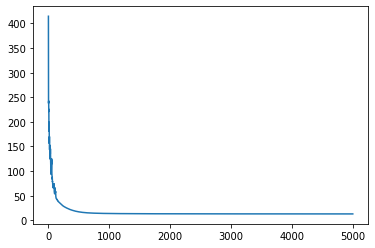

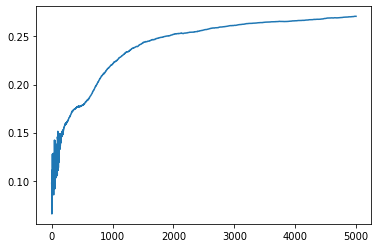

In [8]:
seed = jax.random.PRNGKey(42)
learning_rate = jnp.array(4e-3)
epochs = 5_000
layer_sizes = [128, 10]

initial_weights = InitializeWeights(layer_sizes, seed)
weights = []
for weight in initial_weights:
    weights.append([jnp.copy(weight[0]), jnp.copy(weight[1])])

losses, accuracies = TrainModel(weights, x_train, y_train, learning_rate, epochs, mask = None, verbose_epoches = 100)

plt.plot(losses)
plt.show()

plt.plot(accuracies)
plt.show()

In [9]:
w0_shape = weights[0][0].shape
b0_shape = weights[0][1].shape
w1_shape = weights[1][0].shape
b1_shape = weights[1][1].shape 

all_weights = []
for weight in weights: 
    w = weight[0]
    b = weight[1]
    for row in w:
        for elem in row:
            all_weights.append(elem)
    for elem in b:
        all_weights.append(elem)

all_weights = jnp.abs(jnp.array(all_weights))

In [10]:
def make_mask(prune_indeces):
    mask_w0 = np.ones(w0_shape)
    mask_b0 = np.ones(b0_shape)
    mask_w1 = np.ones(w1_shape)
    mask_b1 = np.ones(b1_shape)
    for index in prune_indeces:
        if index < w0_shape[0] * w0_shape[1]:
            first_index = index // w0_shape[1]
            second_index = index % w0_shape[1]
            mask_w0[first_index, second_index] = 0
        elif index < w0_shape[0] * w0_shape[1] + b0_shape[0]:
            mask_b0[index - (w0_shape[0] * w0_shape[1])] = 0
        elif index < w0_shape[0] * w0_shape[1] + b0_shape[0] + w1_shape[0] * w1_shape[1]:
            first_index = (index - (w0_shape[0] * w0_shape[1] + b0_shape[0])) // w1_shape[1]
            second_index = (index - (w0_shape[0] * w0_shape[1] + b0_shape[0])) % w1_shape[1]
            mask_w0[first_index, second_index] = 0
        else:
            mask_b1[index - (w0_shape[0] * w0_shape[1] + b0_shape[0] + w1_shape[0] * w1_shape[1])] = 0

    return [[jnp.array(mask_w0), jnp.array(mask_b0)], [jnp.array(mask_w1), jnp.array(mask_b1)]]

## Total Search

In [ ]:
masks = {}
results = {}
results[0] = {"losses": losses, "accuracies": accuracies}

for prune_part in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    best_loss = 1e10
    best_model_results = None
    for i in range(20):
        prune_indeces = list(np.random.choice(len(all_weights), size = int(prune_part * len(all_weights)), replace = False))
        masks[prune_part] = make_mask(prune_indeces)
        new_weights = []
        for weight in initial_weights:
            new_weights.append([jnp.copy(weight[0]), jnp.copy(weight[1])])

        print(1-prune_part, "of initial weights, model sample:", i)
        losses, accuracies = TrainModel(new_weights, x_train, y_train, learning_rate, epochs, mask = masks[prune_part])
        if losses[-1] < best_loss:
            best_loss = best_loss
            best_model_results = {"losses": losses, "accuracies": accuracies}

    results[prune_part] = best_model_results

0.4 of initial weights, model sample: 0
Epoch : 0 	 Loss : 207.06 	 Accuracy : 0.097300
Epoch : 100 	 Loss : 46.19 	 Accuracy : 0.100580
Epoch : 200 	 Loss : 33.52 	 Accuracy : 0.102340
Epoch : 300 	 Loss : 28.55 	 Accuracy : 0.103700
Epoch : 400 	 Loss : 24.78 	 Accuracy : 0.104620
Epoch : 500 	 Loss : 22.03 	 Accuracy : 0.104100
Epoch : 600 	 Loss : 19.87 	 Accuracy : 0.104580
Epoch : 700 	 Loss : 18.17 	 Accuracy : 0.104640
Epoch : 800 	 Loss : 16.86 	 Accuracy : 0.104560
Epoch : 900 	 Loss : 15.86 	 Accuracy : 0.104900
Epoch : 1000 	 Loss : 15.12 	 Accuracy : 0.104720
Epoch : 1100 	 Loss : 14.58 	 Accuracy : 0.104460
Epoch : 1200 	 Loss : 14.20 	 Accuracy : 0.103980
Epoch : 1300 	 Loss : 13.92 	 Accuracy : 0.103680
Epoch : 1400 	 Loss : 13.72 	 Accuracy : 0.104080
Epoch : 1500 	 Loss : 13.57 	 Accuracy : 0.104140
Epoch : 1600 	 Loss : 13.46 	 Accuracy : 0.104140
Epoch : 1700 	 Loss : 13.38 	 Accuracy : 0.103960
Epoch : 1800 	 Loss : 13.31 	 Accuracy : 0.103860
Epoch : 1900 	 Loss :

In [2]:
# results = {
#           0: {"losses": [12.96], "accuracies": [0.275360]},
#           0.1: {"losses": [12.95], "accuracies": [0.235900]},
#           0.2: {"losses": [12.94], "accuracies": [0.207140]},
#           0.3: {"losses": [12.94], "accuracies": [0.169600]}, 
#           0.4: {"losses": [12.95], "accuracies": [0.151140]},
#           0.5: {"losses": [12.89], "accuracies" : [0.141760]},
#           0.6: {"losses": [12.91], "accuracies" : [0.122800]},
#           0.7: {"losses": [12.92], 	"accuracies": [0.116800]},
#           0.8: {"losses": [12.90], 	"accuracies": [0.128200]},
#           0.9: {"losses": [12.94], 	"accuracies": [0.103420]}
#           }

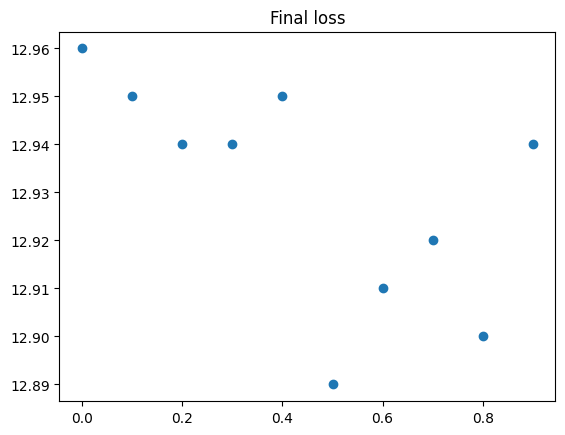

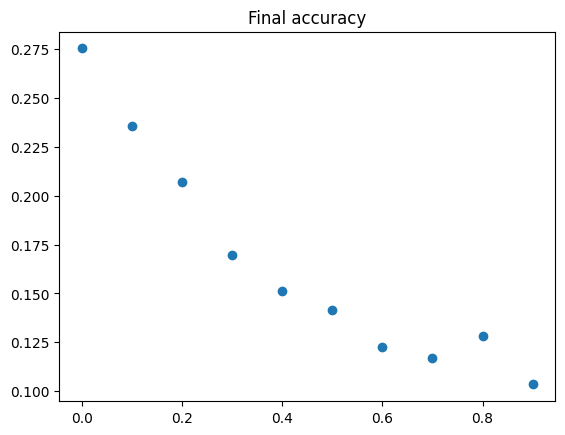

In [3]:
plt.scatter([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [results[x]["losses"][-1] for x in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])
plt.title("Final loss")
plt.show()

plt.scatter([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [results[x]["accuracies"][-1] for x in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])
plt.title("Final accuracy")
plt.show()

## Prune the minimal absolute weights
The method from here: https://arxiv.org/pdf/1803.03635.pdf 

In [11]:
results = {}
results[0] = {"losses": losses, "accuracies": accuracies}

masks = {}

for prune_part in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    prune_indeces = all_weights.argsort()[:int(prune_part * len(all_weights))]
    masks[prune_part] = make_mask(prune_indeces)

for prune_part in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(1-prune_part, "of initial weights")
    new_weights = []
    for weight in initial_weights:
        new_weights.append([jnp.copy(weight[0]), jnp.copy(weight[1])])
    losses, accuracies = TrainModel(new_weights, x_train, y_train, learning_rate, epochs, mask = masks[prune_part])

    results[prune_part] = {"losses": losses, "accuracies": accuracies}

0.9 of initial weights
Epoch : 0 	 Loss : 359.91 	 Accuracy : 0.097300
Epoch : 100 	 Loss : 47.71 	 Accuracy : 0.121980
Epoch : 200 	 Loss : 32.41 	 Accuracy : 0.142280
Epoch : 300 	 Loss : 24.78 	 Accuracy : 0.150420
Epoch : 400 	 Loss : 20.10 	 Accuracy : 0.158600
Epoch : 500 	 Loss : 17.22 	 Accuracy : 0.168380
Epoch : 600 	 Loss : 15.63 	 Accuracy : 0.175780
Epoch : 700 	 Loss : 14.77 	 Accuracy : 0.184240
Epoch : 800 	 Loss : 14.29 	 Accuracy : 0.191600
Epoch : 900 	 Loss : 13.99 	 Accuracy : 0.200020
Epoch : 1000 	 Loss : 13.79 	 Accuracy : 0.206940
Epoch : 1100 	 Loss : 13.65 	 Accuracy : 0.211600
Epoch : 1200 	 Loss : 13.55 	 Accuracy : 0.216560
Epoch : 1300 	 Loss : 13.46 	 Accuracy : 0.221480
Epoch : 1400 	 Loss : 13.40 	 Accuracy : 0.225220
Epoch : 1500 	 Loss : 13.35 	 Accuracy : 0.227560
Epoch : 1600 	 Loss : 13.31 	 Accuracy : 0.229640
Epoch : 1700 	 Loss : 13.27 	 Accuracy : 0.232280
Epoch : 1800 	 Loss : 13.24 	 Accuracy : 0.233380
Epoch : 1900 	 Loss : 13.22 	 Accuracy

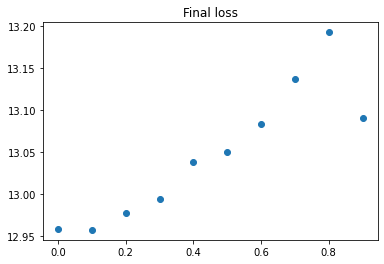

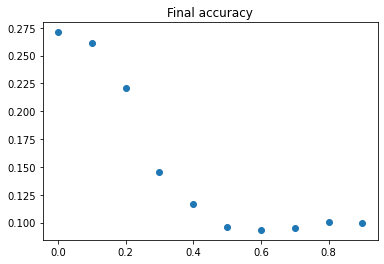

In [12]:
plt.scatter([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [results[x]["losses"][-1] for x in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])
plt.title("Final loss")
plt.show()

plt.scatter([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [results[x]["accuracies"][-1] for x in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])
plt.title("Final accuracy")
plt.show()